# LandTrendr Implementation For Decadal Averaging of Spectral Indices

### Requirements: 

Python:

* geemap
* ee
* matplotlib
* numpy
* pandas
* oeel ** 

Other:
* Google Earth Engine Account

The LandTrendr algorithm is highly efficient and extensive tool with documentation at this link: https://emapr.github.io/LT-GEE/

This version uses the latest processing efforts of the Landsat TM+ ETM+ and OLI collection 2

** this package allows the user to run GEE modules directly without the pitfalls of translating JS to Python.

In [1]:
import ee
import geemap
import geemap.ml as ml
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr
import os
# Import date class from datetime module
from datetime import datetime as dt
import datetime
import pytz

### save the date as a variable to use for version control

In [2]:
today = dt.today()
print("Today is: ", today)

Today is:  2023-03-31 16:34:00.739397


# GEE Authentication 
 
 ### Paste the Authetication code into the box below if prompted to save token
 
 
 (press enter to save token)


In [3]:
#ee.Authenticate()

In [4]:
geemap.ee_initialize()

### New version control of inputs and outputs

* best to check that catchment hydroclimatic information is indeed the most reliable/latest available

In [5]:
p = '..'

version = 'Version_3_20230303'

l_BE = pd.read_excel(f"{p}\Inputs\Version_3_20230303\BE.xlsx").catchment.tolist()
l_FR = pd.read_excel(f"{p}\Inputs\Version_3_20230303\FR.xlsx").catchment.tolist()

ls = l_BE+l_FR

def drop_space(i) -> str:
    '''
    Since the FR and BE data is given with indices using catchment names,
    it is necessary to check and drop the space at the end of each name where applicable.
    
    list the letters, check the last charachter for a space and delete if necessary. 
    '''
    
    ls = list(i)
    
    if ls[-1] == ' ':
        i = i[:-1]
    else:
        i = i
    return i


names = [drop_space(i) for i in ls]

print(f'{len(names)} catchments processed for hydroclimatic variables:\n \n{names}')

22 catchments processed for hydroclimatic variables:
 
['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho', 'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville']



### Load the JS Module

The custom JS module takes the difficult javascript functions that do not translate well to python, and makes them callable in the notebook environment. 

Current version 6 improves the classifier by using a weighted training strategy.

This custom module borrows some functions from the LandTrendr module developed by Justin Braaten (Google) which is classified under an apache license i.e. free for use). The adaptation begins from landTrendr version 0.2 which incorporated Landsat Collection 2, removing the need for regression coefficients between sensors developed by roy et. al.

In [6]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v6.js')

ltgee.availability  #all functions within the javascript module


IMPORTANT! Please be advised:
- This version of the Adapted_LT.js modules
  uses some code adapted from the aut/or: @author Justin Braaten (Google) * @author Zhiqiang Yang (USDA Forest Service) * @author Robert Kennedy (Oregon State University)
The latest edits to this code occur: 08/03/2023 for the adaptation efforts by @Mike OHanrahan (TU DELFT MSc research)


{'version': 'string',
 'buildSensorYearCollection': 'function',
 'getSRcollection': 'function',
 'getCombinedSRcollection': 'function',
 'buildSRcollection': 'function',
 'getCollectionIDlist': 'function',
 'countClearViewPixels': 'function',
 'buildClearPixelCountCollection': 'function',
 'removeImages': 'function',
 'LAIcol': 'function',
 'calcIndex': 'function',
 'standardize': 'function',
 'transformSRcollection': 'function',
 'createTrainingImage': 'function',
 'addTerrainBand': 'function',
 'genGCP': 'function',
 'classifier': 'function',
 'classArea': 'function'}

## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository


In [7]:
asset_dir = 'projects/mohanrahan/assets'

catchment_asset = 'CATAPUCII_Catchments/Meuse_Catchments_4326_WFLOW'

dataset = 'Meuse'

crs = 'EPSG:4326'

fignum = 0

RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

startYear = 1984

endYear = 2022

startDay = '06-20'

endDay = '08-31'

maskThese = ['cloud', 'shadow', 'snow',]

bandList = ["B1", "B2", "B3", "B4", "B5", "B7", 
           'NBR', 'NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 
           'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',] 

## The Table Data

- Here the table, a vector of catchments, is loaded from the users' assets in earth engine 

#TODO rewrite to a local .shp

- Two areas are calculated from the EE asset, both in KM^2 , one that is done via the default instance of area from geometry on Earth Engine, the second using a sum of pixels at scake 
- 

In [8]:
table = ee.FeatureCollection(f"{asset_dir}/{catchment_asset}")

def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

def set_area_pixel(feature):
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':crs,
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)

Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', True)  # true ranks from smallest to largest

down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])


df1 = down.loc[down['station_re'].isin(names)]

print(f'The length of the dataframe generated from the EE asset {len(df1)}')

sys_index = df1.index.to_list()

display(df1)

df1.loc[sys_index[-1]]

The length of the dataframe generated from the EE asset 22


,pixel_area,area_km2,station_Y_,station_X_,station_re,station_na
system_index,,,,,,
00000000000000000017,123.921347,123.473771,50.308333,4.827500,Warnant,Warnant
0000000000000000000b,124.878635,124.471389,49.725000,4.710833,La Vence la Francheville,La Vence la Francheville
0000000000000000001c,142.240404,141.760418,50.300000,4.177500,Wiheries,Wiheries
0000000000000000000f,152.489243,151.982904,49.533333,5.802500,La Chiers Longlaville,La Chiers Longlaville
00000000000000000015,162.777877,162.233786,50.208333,4.794167,Hastiere,Hastiere
00000000000000000013,189.952638,189.318019,49.791667,5.385833,Straimont,Straimont
0000000000000000001a,302.637555,301.614998,50.041667,5.127500,Daverdisse,Daverdisse
00000000000000000008,305.818286,304.731203,50.566667,5.169167,Huccorgne,Huccorgne
0000000000000000001f,368.160671,367.091382,48.241667,5.610833,La Meuse Goncourt,La Meuse Goncourt


pixel_area        2681.514071
area_km2          2672.267778
station_Y_          50.466667
station_X_           4.835833
station_re          Salzinnes
station_na    Salzinnes Ronet
Name: 00000000000000000004, dtype: object

In [9]:
len1 = len(df1.station_re.values)
len2 = len(names)

if len1 > len2:
    print(f'catchment{ set(df1.station_re.values).symmetric_difference(names)} is/are missing from the catchment sets')
elif len2 >len1:
    print(f'catchment{ set(df1.station_re.values).symmetric_difference(names)} is/are missing from the EE asset')
else:
    print('The number of catchments with Hydroclimatic indices calculated match the length filtered EE asset\nThere seems to be no mismatch\nContinue... ')

The number of catchments with Hydroclimatic indices calculated match the length filtered EE asset
There seems to be no mismatch
Continue... 


In [16]:
gdf = geemap.ee_to_pandas(Filtered_Sorted)

if not os.path.exists(f'../Outputs/{dataset}/'):
    os.makedirs(f'../Outputs/{dataset}/')

gdf.to_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx', index=0)

In [11]:
Map = geemap.Map()
Map.setOptions('TERRAIN')
Map.addLayer(Filtered_Sorted.filter(ee.Filter.inList('station_re', ee.List(names))), {'color': 'green'}, 'green: Included')
Map.addLayer(Filtered_Sorted.filter(ee.Filter.inList('station_re', ee.List(names)).Not()), {'color':'red'}, 'red: Not Included')
Map.centerObject(Filtered_Sorted, 7)


Map

Map(center=[50.15762767624679, 5.442982293509325], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [12]:
def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)

def image_band_mean(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.mean(),
    'region': aoi,
    'scale': scale,
    'band': band+'_mean',
    })
    
    return chart_ts_region.dataframe

def image_band_median(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': scale,
    'band': band+'_median',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_5(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([5]),
    'region': aoi,
    'scale': scale,
    'band': band+'_p5',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_95(imageCollection, scale, band):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([95]),
    'region': aoi,
    'scale': scale,
    'band': band+'_p95',
    })
    
    return chart_ts_region.dataframe

    
def bands_reduced_toexcel(imcol, scale, ind, band):
    '''
    Takes the bands and returns excel sheets of each catchment:
    ->mean, median, percentile, 
    '''
    df_mean = image_band_mean(imcol, scale, band)
    df_median = image_band_median(imcol, scale, band)
    df_pct5 = image_band_percentile_5(imcol, scale, band)
    df_pct95 = image_band_percentile_95(imcol, scale, band)
    
    
    df_mean.reset_index()
    df_median.reset_index()
    df_pct5.reset_index()
    df_pct95.reset_index()
    
    
    joined= df_mean.join(df_median, how='inner', lsuffix='mean', rsuffix='median')
    joined_pct = df_pct5.join(df_pct95, how='inner', lsuffix='p5', rsuffix='p95')
   
    annual = joined.join(joined_pct, how='inner')
    annual.to_excel(f'../Outputs/{dataset}/timeseries/{ind}_annual_{band}.xlsx')

def extractArea(item):
    
    '''
    Method borrowed from https://code.earthengine.google.co.in/9c45ff677c46eae08952831de02bfb40
    Article: https://spatialthoughts.com/2020/06/19/calculating-area-gee/
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('classification')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])

def classArea(classified_image, scale):
    '''
    This function takes the pixel areas represented by each class the landsat scale is 30m but,
    nominal scale of image is 111000m after medoid compositing
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'classification'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def msToDate(milliseconds):
    base_datetime = datetime.datetime(1970, 1, 1)
    delta = datetime.timedelta(0, 0, 0, milliseconds)
    target_datetime = base_datetime + delta
    return target_datetime

def dataframeAreas(i, yc, classified, trainingClassImage, ms, classImageYear, name, accuracy, pixArea):

    ls1 = pd.DataFrame(classArea(classified, 30).getInfo(), columns=['class', 'area_RF'])
    ls2 = pd.DataFrame(classArea(trainingClassImage, 100).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1.merge(ls2, how='inner', on='class')
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_CORINE', 'area_RF'])
    pivoted['training', 'year_trained'] =  classImageYear
    pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pixArea
    pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    pivoted['testing', 'accuracy'] = accuracy
    pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    
    return pivoted

def normalize (image):
    '''
    This function is used to convert band values to a range between 0 and 1 via normalisation,
    this is typically slow and no improvement to accuracy has been observed yet by its implementation.
    
    The 5 minute loop for an example catchment e.g. Chooz 2012, goes from 
    '''
    bandNames = image.bandNames()
    
def saveClassifierToCSV(classifier, name, yc):
    decisionTrees = ee.List(classifier.explain().get('trees')).getInfo()
    folder='Trees'

    var = f'../Outputs/{dataset}/{folder}/'

    if not os.path.exists(var):
        print('created')
        os.makedirs(var)

    ml.trees_to_csv(decisionTrees, f'../Outputs/Meuse/Trees/{name}_{yc}')

## Running Module over the Shapefile

1. The geometries are called by their system indices (sys_index) updating the 'aoi' and running the process over any  using the indices included in the 
2. The image collection is generated per shapefile and then returns the decadal mean of each index

# TODO:

- Redefine the methodology of reduction. Using chart --> dataframe --> join all dataframes is redundant an probably very slow

In [13]:
scale = 5000 # define the pixel size for reducing, in meters, initially high to reduce comp time


id_ls = 'used_images'
SR_t = 'SR_timeseries'
RF_c = 'RF_classification/'



folder_list = [id_ls, SR_t, RF_c]

for folder in folder_list:
    
    var = f'../Outputs/{dataset}/{folder}'
    
    if not os.path.exists(var):
        print('created')
        os.makedirs(var)

c_1990 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_1990')
c_2000 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_2000')
c_2006 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_2006')
c_2012 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_2012')
c_2018 = ml.csv_to_classifier('../Outputs/Meuse/Trees/Chooz_2018')


In [14]:
'''
Tuning of hyperParameters 'rfParams' is accomplished using this link:

https://code.earthengine.google.com/a1b6b96f28dc3c8998dcc74962b0eb51

JSON printed in the console was plotted in python to find the optimal parameters for 
this purpose. Specifically two years were plotted for the Chooz catchment 1990 vs 2018.

The optimal parameter for each year was identified using overall accuaracy and overall kappa score
Optimal parameter set for all years was determined to be between each.

The parameters are hard coded into the JS module:

Number of trees = 190
Varibles per split = 9
Minimum leaf population = 18
Bag fraction =  0.7
Max nodes = 400
Seed = 0

This results in an accuracy ranging from 84-86% max over the years

'''

classLoopParams = {'dataset':'CORINE', 
               'trainingClassLevel':1,
               'customClassLevels':None,
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':10,            #tileScale higher number reduces likelihood of classifier running into a memory limit
              }

In [ ]:
t0 = dt.today()

classArea_df = pd.DataFrame()




print(f'begin loop: {t0}')

for i, ind in enumerate(sys_index[:1]):

    
    name = df1.loc[ind].station_re
    
    area = df1.loc[ind].area_km2
    
    pix_area = df1.loc[ind].pixel_area
    
    t1 = dt.today()
    
    print(f'\n{i+1}/{len(sys_index)} {t1}\nDataset: {dataset}, \nCatchment: {name}, \nSurface Reflectance Processing ...\n')
    
    aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese)
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)
    print('saving bands to excel')
    band_calc_df = bands_reduced_toexcel(ee.ImageCollection(annual_med_calc), scale, ind, 'B1')
    
    print('calculating LAI')
    
    col = ee.ImageCollection(ltgee.LAIcol(startYear, endYear, startDay, endDay, aoi)) 
    
    lai_calc_df = bands_reduced_toexcel(col, col.first().projection().nominalScale().getInfo(), ind, 'LAI')
    
    '''
    
    Which images are used in creating the annual composites?
    -> return as a list of Landsat image IDs ** 
    ** can be used for exclusion if image quality is suboptimal upon later inspection.. important for small sample cases.
    
    '''
    
    id_key = 'idList'
    
    masked_col_key = 'collection'
    
    print('getting ID collection')
    
#     GetCollectionID = ltgee.getCollectionIDlist(startYear, endYear, startDay, endDay, aoi)
    
#     im_id_list = GetCollectionID[id_key]
    
#     image_list = pd.DataFrame({f'{name}': im_id_list.getInfo()})
    
#     image_list.to_csv(f'../Outputs/{dataset}/used_images/{ind}_imageList.csv')
    
    
    t2 = dt.today()
    
    print(f'step 1: Surface reflectance exported: {t2} \nTime taken: {t2-t1}')
    
    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    
    if dataset == 'Meuse':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - LATER: Will need to use a trained classifier, perhaps the 'best performer', to classify the USA dataset. 
            - Best accuracy may be to take a classifier that samples all 4 categories
        
        '''
        # year_classified = np.arange(1984, 2018)
        year_classified = [1984,1985,1986, 1994,1995,1996,2004,2005,2006,2014,2015,2016]
        
        for j, yc in enumerate(year_classified):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "1990"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            '''
            if yc >= 1984 and yc < 1999:
                classifier = c_1990
                classImageYear = 1990

            elif yc >= 1999 and yc < 2004:
                classifier = c_2000
                classImageYear = 2000

            elif yc >= 2004 and yc < 2010:
                classifier = c_2006
                classImageYear = 2006

            elif yc >= 2010 and yc < 2015:
                classifier = c_2012
                classImageYear = 2012

            elif yc >= 2015:
                classifier = c_2018
                classImageYear = 2018

            else:
                print('ERROR: year to classify out of range[1984 - 2022]')
                break
            
            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first().clip(aoi)
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(str(classImageYear), classLoopParams['dataset'], classLoopParams['trainingClassLevel'], aoi)
            
            
            #Adding the elevation and slope band calculations to each image
            imageToClassify = ltgee.addTerrainBand(imageFromCollection, aoi)
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage, imageToClassify, classLoopParams['numClasses'], classLoopParams['split'], classLoopParams['tileScale'], aoi, 'weighted')
            
            # 70% of the points are allocated to training
            training = points['training']
            
            #30% of the points are allocated to classification
            testing = points['testing']
            
            t5 = dt.today()
            
            # classifier training with predefined number of trees using training points
            # classifier = ltgee.classifier(imageToClassify, training)
            
            t6 = dt.today()
            
            #saving decision trees for later use
            # saveClassifierToCSV(classifier, name, yc)
            
#             #classifying image using the training
            classified = imageToClassify.classify(classifier)
            
            focal = classified.focalMode(**{'radius':30,
                                          'kernelType':'square',
                                          'units':'meters',
                                          'iterations':2}).clip(aoi)
            
            # Map.addLayer(focal, {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']}, f'{name} RF:{j}.{yc}.{classImageYear}')

#           #assess the accuracy using the testing points, see where the confusion occurs
            accuracy = testing.classify(classifier).errorMatrix('landcover', 'classification').accuracy().getInfo()
            print(f'{yc} classified using: {classImageYear} ...  \naccuracy: {accuracy:.3f}')


            df = dataframeAreas(i, j, classified, trainingClassImage, ms, classImageYear, name, accuracy, pix_area)
            
            df.to_csv(f'../Outputs/{dataset}/RF_classification/{ind}_{yc}_classes.csv')
            
            classArea_df = classArea_df.append(df)
            
    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    
    print(f'step2: Done: {t4}, time taken: {t4-t3}')
    
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')
    
#     if ind == sys_index[0]:
#         break



tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-03-31 18:32:13.728585

1/22 2023-03-31 18:32:13.730608
Dataset: Meuse, 
Catchment: Warnant, 
Surface Reflectance Processing ...

saving bands to excel
calculating LAI


In [ ]:
sys_index #Huccorgne is 7 ... start on la bar cheuve

In [ ]:
translation = [('ndvi','Normalized Difference Vegetation Index'), ('')]

In [ ]:
accuracy = [0.763,0.810,0.8,0.831,0.831,0.826,0.945,0.810,0.803,0.794,0.826,0.793,0.759,0.782,0.769,0.856,0.957,0.832,0.803,0.826,0.708,0.824,0.955,0.740,0.780,0.847,0.684,0.718,0.960,0.746,0.684,0.819,0.806,0.759]

In [ ]:
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(classified, {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']})
Map

In [18]:
classArea_df.keys()

MultiIndex([('area_CORINE',            '1'),
            ('area_CORINE',            '2'),
            ('area_CORINE',            '3'),
            ('area_CORINE',            '4'),
            ('area_CORINE',            '5'),
            (    'area_RF',            '1'),
            (    'area_RF',            '2'),
            (    'area_RF',            '3'),
            (    'area_RF',            '4'),
            (    'area_RF',            '5'),
            (   'training', 'year_trained'),
            ('area_CORINE',            '6'),
            (  'catchment',         'area'),
            (    'area_RF',            '6'),
            (  'catchment',        'name '),
            (    'testing',     'accuracy'),
            (        'ind',             '')],
           names=[None, 'class'])

In [38]:
classArea_df.to_excel('ClassArea_test.xlsx', merge_cells=True)

<AxesSubplot:xlabel='image_date'>

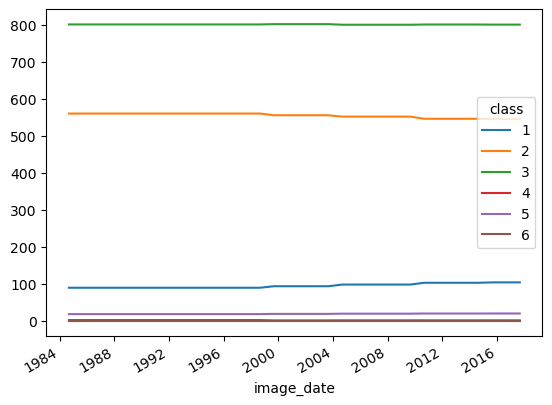

In [68]:
classArea_df1 = pd.read_excel('chooz_weighted.xlsx', header=[0,1], index_col=[0], parse_dates=True)
acc = pd.Series(accuracy)
classArea_df1.testing['accuracy2'] = acc
classArea_df1.area_CORINE.plot()

In [70]:
classArea_df1.keys()

MultiIndex([('area_CORINE',                   '1'),
            ('area_CORINE',                   '2'),
            ('area_CORINE',                   '3'),
            ('area_CORINE',                   '4'),
            ('area_CORINE',                   '5'),
            (    'area_RF',                   '1'),
            (    'area_RF',                   '2'),
            (    'area_RF',                   '3'),
            (    'area_RF',                   '4'),
            (    'area_RF',                   '5'),
            (   'training',        'year_trained'),
            ('area_CORINE',                   '6'),
            (  'catchment',                'area'),
            (    'area_RF',                   '6'),
            (  'catchment',               'name '),
            (    'testing',            'accuracy'),
            (        'ind', 'Unnamed: 17_level_1')],
           names=[None, 'class'])

In [71]:
class_name = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies', 'Masked']

rdx = classArea_df1.reset_index().fillna(0)
for i in range(6):
    print(class_name[i], np.mean(rdx.area_CORINE.iloc[:,i]/rdx.catchment.area))

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

rdx

Artificial 0.06451778179469594
Agricultural 0.3770746305489745
Forest and Semi-Natural 0.5444791136943509
Wetlands 0.001106081416646922
Waterbodies 0.012887045460919235
Masked 0.0
Artificial 0.06723639737794404
Agricultural 0.3358281378129768
Forest and Semi-Natural 0.5378977801681827
Wetlands 0.011614808730090354
Waterbodies 0.02542709608022902
Masked 0.08923217720852111


image_date area_CORINE                                    \
class                               1           2           3         4   
0     1984-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
1     1985-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
2     1986-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
3     1987-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
4     1988-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
5     1989-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
6     1990-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
7     1991-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
8     1992-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
9     1993-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
10    1994-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
11    1995-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
12    1996-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
13    1997-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
14    1998-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
15    1999-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
16    2000-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
17    2001-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
18    2002-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
19    2003-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
20    2004-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
21    2005-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
22    2006-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
23    2007-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
24    2008-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
25    2009-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
26    2010-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
27    2011-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
28    2012-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
29    2013-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
30    2014-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
31    2015-08-31 22:00:00  104.061006  545.604586  801.032115  1.373331   
32    2016-08-31 22:00:00  104.061006  545.604586  801.032115  1.373331   
33    2017-08-31 22:00:00  104.061006  545.604586  801.032115  1.373331   

                     area_RF                                                \
class          5           1           2           3          4          5   
0      18.307640   83.964745  677.037061  677.831171   1.929748  26.603761   
1      18.307640   73.123634  490.730324  846.781498  23.945523  32.665004   
2      18.307640   74.809540  496.186339  847.762169  11.174912  34.209218   
3      18.307640   68.286624  458.004928  874.303031  27.772361  39.004204   
4      18.307640   82.811368  471.138171  856.151316  18.980731  37.373257   
5      18.307640   91.363037  429.259205  872.842711  34.732112  39.174083   
6      18.307640   91.778350  516.768841  817.660834   5.980818  35.182306   
7      18.307640   77.968981  479.770912  854.879574  16.840448  37.911234   
8      18.307640   97.691768  578.045998  753.158823   2.126429  35.119384   
9      18.307640   62.817133  278.626446  592.673866  17.459635  37.827160   
10     18.307640  107.746138  350.190700  852.246132  38.328340  44.628511   
11     18.307640   70.303428  310.155415  990.758185  51.156088  44.998033   
12     18.307640   83.668352  313.124876  770.748496  60.913799  29.826032   
13     18.307640   66.195710  318.741538  974.453988  42.560149  43.715394   
14     18.307640  108.172329  414.871033  860.359927  35.825361  4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Artificial 0.06723639737794404
Agricultural 0.3358281378129768
Forest and Semi-Natural 0.5378977801681827
Wetlands 0.011614808730090354
Waterbodies 0.02542709608022902
Masked 0.08923217720852111
Fixed Mask -0.021995779830576948


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


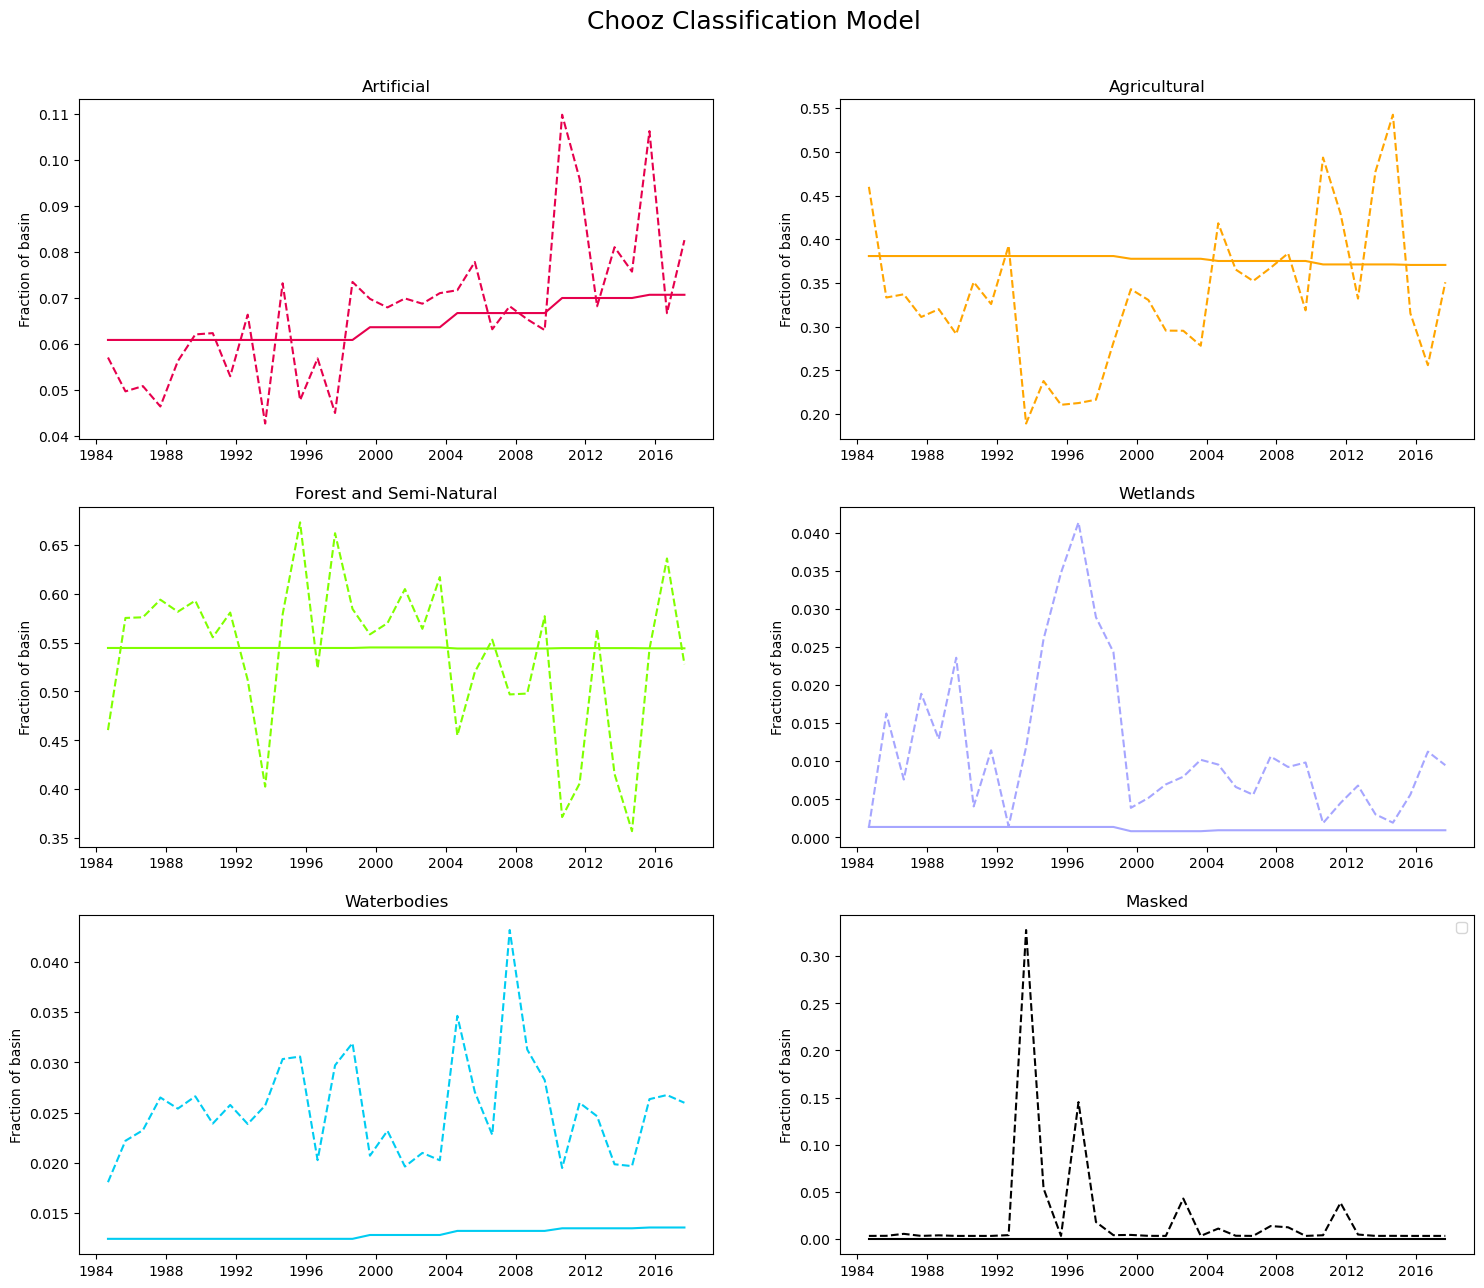

In [72]:

rdx = classArea_df1.reset_index().fillna(0)
# rdx.area_RF.iloc[:, 5] = rdx.area_RF.iloc[:,0:4].sum(axis=1) - rdx.catchment.area
rdx[('area_RF', 'masked')] = rdx.area_RF.iloc[:,0:5].sum(axis=1) - rdx.catchment.area

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

print('Fixed Mask', np.mean(rdx.area_RF.masked/rdx.catchment.area))


grouped = rdx.groupby('image_date').sum()
grouped

grouped = rdx.groupby('image_date').sum()

colors = ['#E6004D', 'orange', '#80FF00', '#A6A6FF', '#00CCF2', 'black']

fig, axes = plt.subplots(3,2, figsize = (18,15))

tit = plt.suptitle('Chooz Classification Model', y=0.94, size=18)

for i in range(6):
    if i == 0:
        col=0
        row=0
    elif i==1:
        col=1
        row=0
    elif i==2:
        col=0
        row=1
    elif i==3:
        col=1
        row=1
    elif i==4:
        col=0
        row=2
    
    if i<5:
        ax = axes[row, col]
        ax.set_title(class_name[i])
        ax.plot(grouped.area_RF.iloc[:,i]/grouped.catchment.area,linestyle='dashed', c=colors[i], label=f'{class_name[i]} modelled')
        ax.plot(grouped.area_CORINE.iloc[:,i]/grouped.catchment.area, c=colors[i], label=f'{class_name[i]} corine')
        ax.set_ylabel('Fraction of basin')
        plt.legend()
    
    if i==5:
        col=1
        row=2
        ax = axes[row, col]
        ax.set_title(class_name[i])
        ax.plot(grouped.area_RF.masked.abs()/grouped.catchment.area, linestyle='dashed', c=colors[i], label= f'')
        ax.plot(grouped.area_CORINE.iloc[:,i]/grouped.catchment.area, c=colors[i])
        ax.set_ylabel('Fraction of basin')



In [73]:
class_search = pd.read_excel('../Outputs/meuse/RF_classification/preTuning/classifier_search.xlsx', header=[0,1], index_col=0, parse_dates=True)
class_search.keys()

MultiIndex([('area_CORINE',                   '1'),
            ('area_CORINE',                   '2'),
            ('area_CORINE',                   '3'),
            ('area_CORINE',                   '4'),
            ('area_CORINE',                   '5'),
            (    'area_RF',                   '1'),
            (    'area_RF',                   '2'),
            (    'area_RF',                   '3'),
            (    'area_RF',                   '4'),
            (    'area_RF',                   '5'),
            (   'training',        'year_trained'),
            ('area_CORINE',                   '6'),
            (  'catchment',                'area'),
            (    'area_RF',                   '6'),
            (  'catchment',               'name '),
            (    'testing',            'accuracy'),
            (        'ind', 'Unnamed: 17_level_1')],
           names=[None, 'class'])

In [74]:
year_classified = [1990, 2000, 2006, 2012, 2018]

for year in year_classified:
    class_search.groupby(('training', 'year_trained')).get_group(year).sort_values(by=('testing', 'accuracy'), ascending=False).to_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year}.xlsx')

In [75]:
catchment = ['Chooz', 'Chooz', 'Chooz', 'treignes', 'Chooz']
accuracy = [0.789369, 0.783634, 0.803112, 0.796622, 0.796321]
acc_post = [0.945, 0.957, 0.955, 0.960, 0.956]
group = pd.read_excel(f'../Outputs/meuse/RF_classification/preTuning/classifier_ranking_{year_classified[4]}.xlsx', header=[0,1], index_col=0, parse_dates=True).dropna()
group

area_CORINE                                               \
class                         1           2           3         4          5   
image_date                                                                     
2018-08-31 22:00:00  108.696124  600.561064  859.017972  1.373331  19.890701   
2018-08-31 22:00:00   35.427795  218.596639  292.070370  0.907128   1.304537   
2018-08-31 22:00:00    6.957725  263.506508  130.410072  2.640857   2.294175   

                        area_RF                                                \
class                         1           2           3          4          5   
image_date                                                                      
2018-08-31 22:00:00  166.729849  494.983704  788.659230  77.415980  57.183356   
2018-08-31 22:00:00   73.821864  172.814694  255.115498  38.918854   5.460617   
2018-08-31 22:00:00   59.673091  185.001977  125.209307  26.706760   7.395682   

                        training area_CORINE    catchment     area_RF  \
class               year_trained           6         area           6   
image_date                                                              
2018-08-31 22:00:00         2018           0  1589.539192  171.296922   
2018-08-31 22:00:00         2018           0   548.306470   75.996808   
2018-08-31 22:00:00         2018           0   405.809337   61.495611   

                            catchment   testing                 ind  
class                           name   accuracy Unnamed: 17_level_1  
image_date                                                           
2018-08-31 22:00:00             Chooz  0.796321                 0_4  
2018-08-31 22:00:00          Treignes  0.784553                 6_4  
2018-08-31 22:00:00  La Bar Cheveuges  0.774127                 8_4

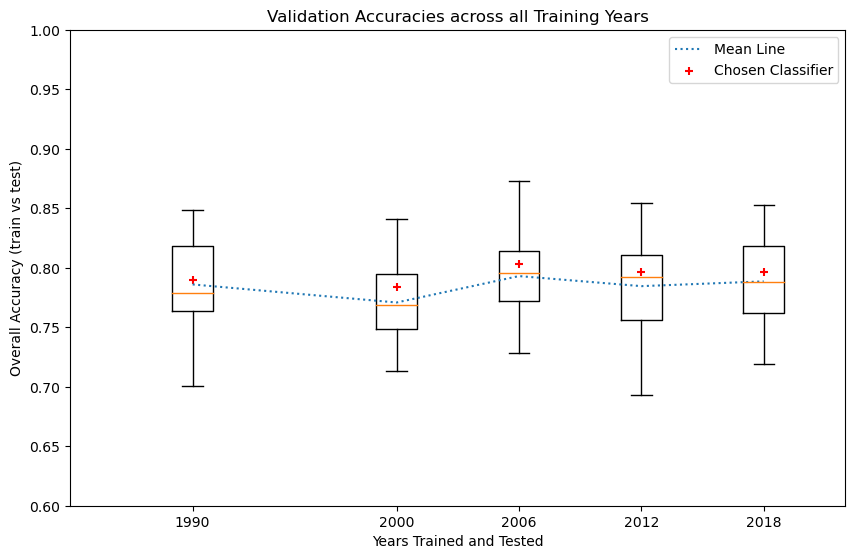

In [83]:
fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = class_search.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')

ax.set_xlabel('Years Trained and Tested')
ax.set_ylabel('Overall Accuracy (train vs test)')
ax.set_ylim(0.6, 1)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

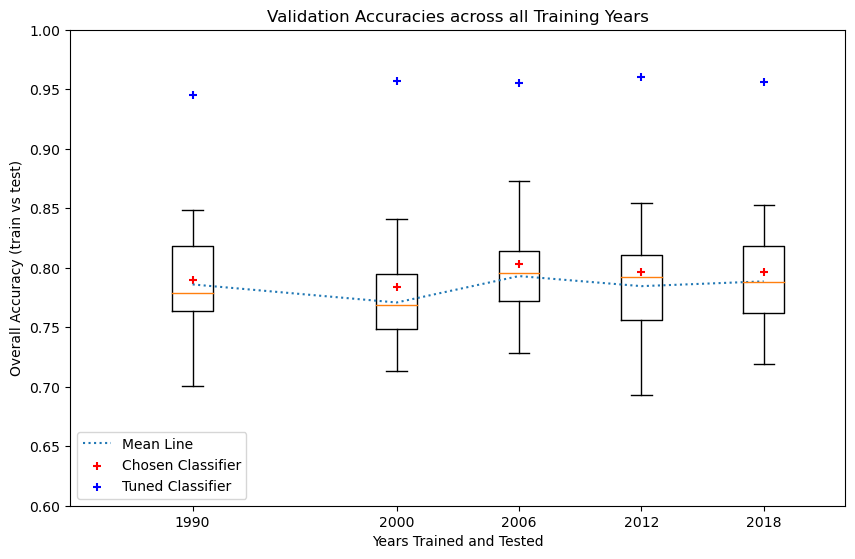

In [86]:
fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')
ax.scatter(year_classified, acc_post, marker='+', c='b', label='Tuned Classifier')
ax.set_xlabel('Years Trained and Tested')
ax.set_ylabel('Overall Accuracy (train vs test)')
ax.set_ylim(0.6, 1)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

In [ ]:
fig,ax = plt.subplots()
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('area_RF',     '6')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='mean line')
# ax.set_ylim(0.6, 0.9)
# ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Masked Pixels across all Training Years');

In [224]:
groups.get_group(1990)[('area_RF',     '6')].values

array([  170.04494064, -1121.04137693, -1990.        ,   288.9496701 ,
       -1188.77559444, -1507.10129803,    81.80562092, -1990.        ,
          57.5897379 , -1990.        , -1990.        , -1639.97102917,
       -1747.56122536, -1990.        , -1990.        , -1855.4575343 ,
       -1990.        , -1990.        , -1990.        , -1852.2925636 ,
       -1990.        , -1990.        ])

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map